In [1]:
import pandas as pd
import numpy as np
import json
from scipy import sparse as sp
from tqdm.notebook import tqdm
from collections import defaultdict

In [2]:
import implicit

In [3]:
import sys
sys.path.append('../')

from src.utils import get_shard_path
from src.utils import ProductEncoder, make_coo_row
from src.metrics import normalized_average_precision

In [6]:
product_encoder = ProductEncoder('../data/raw/products.csv')

In [7]:
valid_data = [json.loads(l) for l in open(get_shard_path(7))][:3000]

In [9]:
rows = []
for shard_id in range(4):
    for js in tqdm(json.loads(l) for l in open(get_shard_path(shard_id))):
        rows.append(make_coo_row(js["transaction_history"], product_encoder))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [10]:
len(rows)


183938

In [11]:
X_sparse = sp.vstack(rows).tocsr()

In [12]:
X_sparse.shape

(183938, 43038)

In [13]:
X_sparse

<183938x43038 sparse matrix of type '<class 'numpy.float32'>'
	with 12918657 stored elements in Compressed Sparse Row format>

# ALS

In [14]:
model = implicit.als.AlternatingLeastSquares(factors=16, regularization=0.0, iterations=8)
model.fit(X_sparse) #!!!!!!!!!!!!!!!

C:\Users\Kolya\anaconda3\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 6 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()


  0%|          | 0/8 [00:00<?, ?it/s]

In [15]:
m_ap = []
for js in tqdm(valid_data):
    row_sparse = make_coo_row(js["transaction_history"], product_encoder).tocsr()
    raw_recs = model.recommend(
        0, 
        row_sparse, #текущий пользователь, для которого рекомендуем
        N=30, 
        filter_already_liked_items=False, 
        recalculate_user=True
    )
    recommended_items = product_encoder.toPid([x for x in raw_recs[0]])
    gt_items = js["target"][0]["product_ids"]
    m_ap.append(normalized_average_precision(gt_items, recommended_items, k=30))
print(np.mean(m_ap))

  0%|          | 0/3000 [00:00<?, ?it/s]

0.0563243389167934


In [16]:
raw_recs

(array([12454, 39321,  4740, 14501,  1713, 37296, 34153, 41355, 38802,
         8809, 12790, 18300, 39153, 39862, 33094, 36370,  1337, 26079,
        19081, 41915,  7049,  8833, 15237, 23687,  6458, 24038, 22301,
         2157, 42416,  7093]),
 array([9.9869883e-01, 4.8781456e-03, 4.2006592e-03, 3.9935559e-03,
        3.3000666e-03, 1.6659513e-03, 1.1262754e-03, 1.0927606e-03,
        1.0497860e-03, 9.9400885e-04, 9.6200127e-04, 9.5571694e-04,
        9.5389877e-04, 9.4398687e-04, 9.2543603e-04, 8.9187082e-04,
        8.6740009e-04, 7.3385460e-04, 7.0404232e-04, 6.6736666e-04,
        6.3714257e-04, 6.1614439e-04, 6.0862821e-04, 5.7638425e-04,
        5.5385235e-04, 5.4432702e-04, 5.3811661e-04, 5.3353788e-04,
        5.1308575e-04, 4.8589674e-04], dtype=float32))

0.053
раньше было лучше...
уберём нормировку - переопределим функцию make_coo_row:

## Без нормировки

In [17]:
def make_coo_row(transaction_history, product_encoder: ProductEncoder):
    idx = []
    values = []

    items = []
    for trans in transaction_history:
        items.extend([i["product_id"] for i in trans["products"]])
    n_items = len(items)

    for pid in items:
        idx.append(product_encoder.toIdx(pid))
        values.append(1.0)

    return sp.coo_matrix(
        (np.array(values).astype(np.float64), ([0] * len(idx), idx)), shape=(1, product_encoder.num_products),
    )

In [18]:
rows = []
for shard_id in range(4):
    for js in tqdm(json.loads(l) for l in open(get_shard_path(shard_id))):
        rows.append(make_coo_row(js["transaction_history"], product_encoder))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [19]:
X_sparse = sp.vstack(rows).tocsr()

In [20]:
model = implicit.als.AlternatingLeastSquares(factors=16, regularization=0.0, iterations=8)
model.fit(X_sparse) #!!!!!!!!!!!!!!!

  0%|          | 0/8 [00:00<?, ?it/s]

In [21]:
m_ap = []
for js in tqdm(valid_data):
    row_sparse = make_coo_row(js["transaction_history"], product_encoder).tocsr()
    raw_recs = model.recommend(
        0, #id пользователя
        row_sparse, #текущий пользователь, для которого рекомендуем
        N=30, 
        filter_already_liked_items=False, 
        recalculate_user=True
    )
    recommended_items = product_encoder.toPid([x for x in raw_recs[0]])
    gt_items = js["target"][0]["product_ids"]
    m_ap.append(normalized_average_precision(gt_items, recommended_items, k=30))
print(np.mean(m_ap))

  0%|          | 0/3000 [00:00<?, ?it/s]

0.07142410387835837


## factors?

In [22]:
m_ap_arr = []
for factors in [1, 2, 5, 10, 16, 30, 50]:
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.0, iterations=8)
    model.fit(X_sparse) #!!!!!!!!!!!!!!!
    m_ap = []
    for js in tqdm(valid_data):
        row_sparse = make_coo_row(js["transaction_history"], product_encoder).tocsr()
        raw_recs = model.recommend(
            0, #id пользователя
            row_sparse, #текущий пользователь, для которого рекомендуем
            N=30, 
            filter_already_liked_items=False, 
            recalculate_user=True
        )
        recommended_items = product_encoder.toPid([x for x in raw_recs[0]])
        gt_items = js["target"][0]["product_ids"]
        m_ap.append(normalized_average_precision(gt_items, recommended_items, k=30))
    m_ap_arr.append(np.mean(m_ap))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [23]:
import matplotlib.pyplot as plt

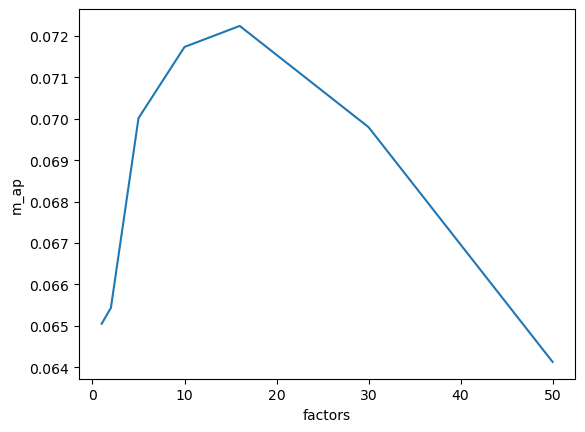

In [24]:
plt.plot([1, 2, 5, 10, 16, 30, 50], m_ap_arr)
plt.xlabel("factors")
plt.ylabel("m_ap")
plt.show()